In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point

import plotly.graph_objs as go
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

In [2]:
credits = pd.read_csv('../data/credits.csv')
keywords = pd.read_csv('../data/keywords.csv')
movies = pd.read_csv('../data/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [3]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [5]:
df['production_countries'].to_csv('production_countries.csv', index=False, header=['production_countries'])

In [6]:
# Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [14]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

# DATA VISUALIZATION

check the type range

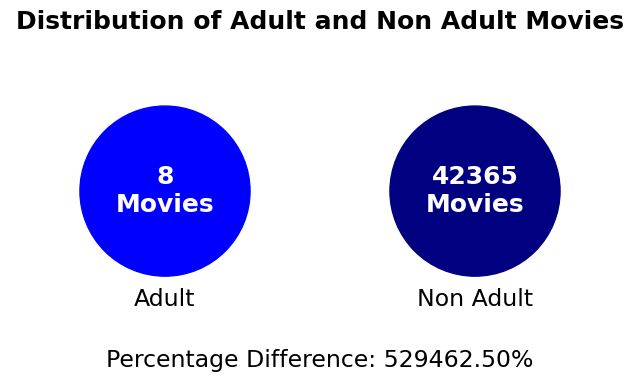

In [40]:
plt.figure(figsize=(8, 4))

# Scatter plot with blue and navy colors
plt.scatter(x=[0.5, 1.5], y=[1, 1], s=15000, color=['blue', 'navy'])

# Set x-axis and y-axis limits
plt.xlim(0, 2)
plt.ylim(0.9, 1.1)

# Title with blue color
plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='black')

# Text labels for the number of movies with white color
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult'] == 'True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult'] == 'False']))), va='center', ha='center', fontsize=18, weight=600, color='white')

# Text labels for Adult and Non Adult with navy color
plt.text(0.5, 0.93, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='black')
plt.text(1.5, 0.93, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='black')


adult_count = len(df[df['adult'] == 'True'])
non_adult_count = len(df[df['adult'] == 'False'])
percentage_difference = ((non_adult_count - adult_count) / adult_count) * 100
# Text label for percentage difference with navy color
plt.text(1, 0.89, 'Percentage Difference: {:.2f}%'.format(percentage_difference), va='center', ha='center', fontsize=17, color='black')


# Turn off axis
plt.axis('off')

# Show the plot
plt.show()

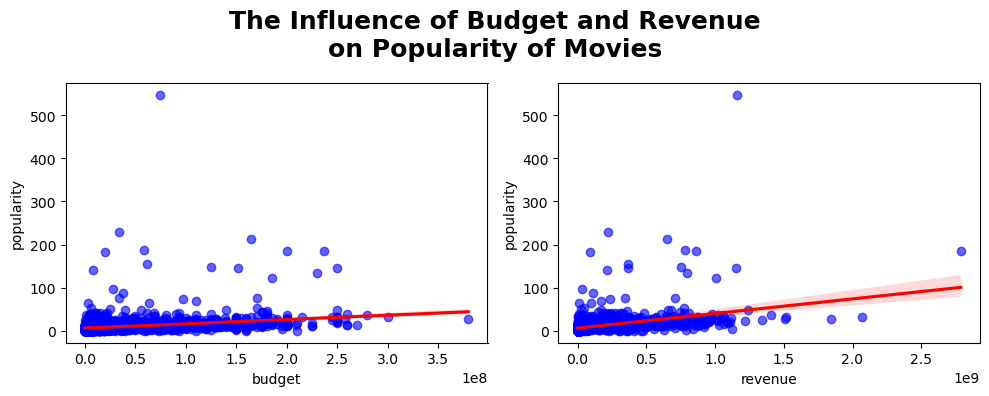

In [43]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='black')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#0000FF", "alpha": 0.6}, line_kws={"color": "#FF0000"}, ax=axes[i])

plt.tight_layout()

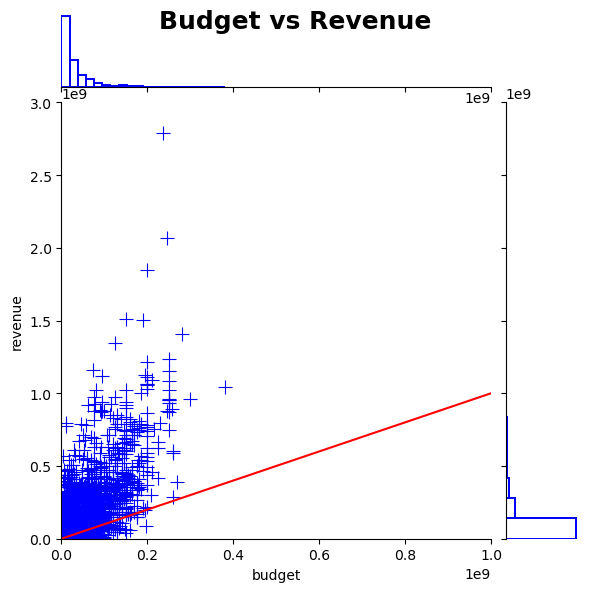

In [45]:

ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='blue')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='black')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#FF0000')

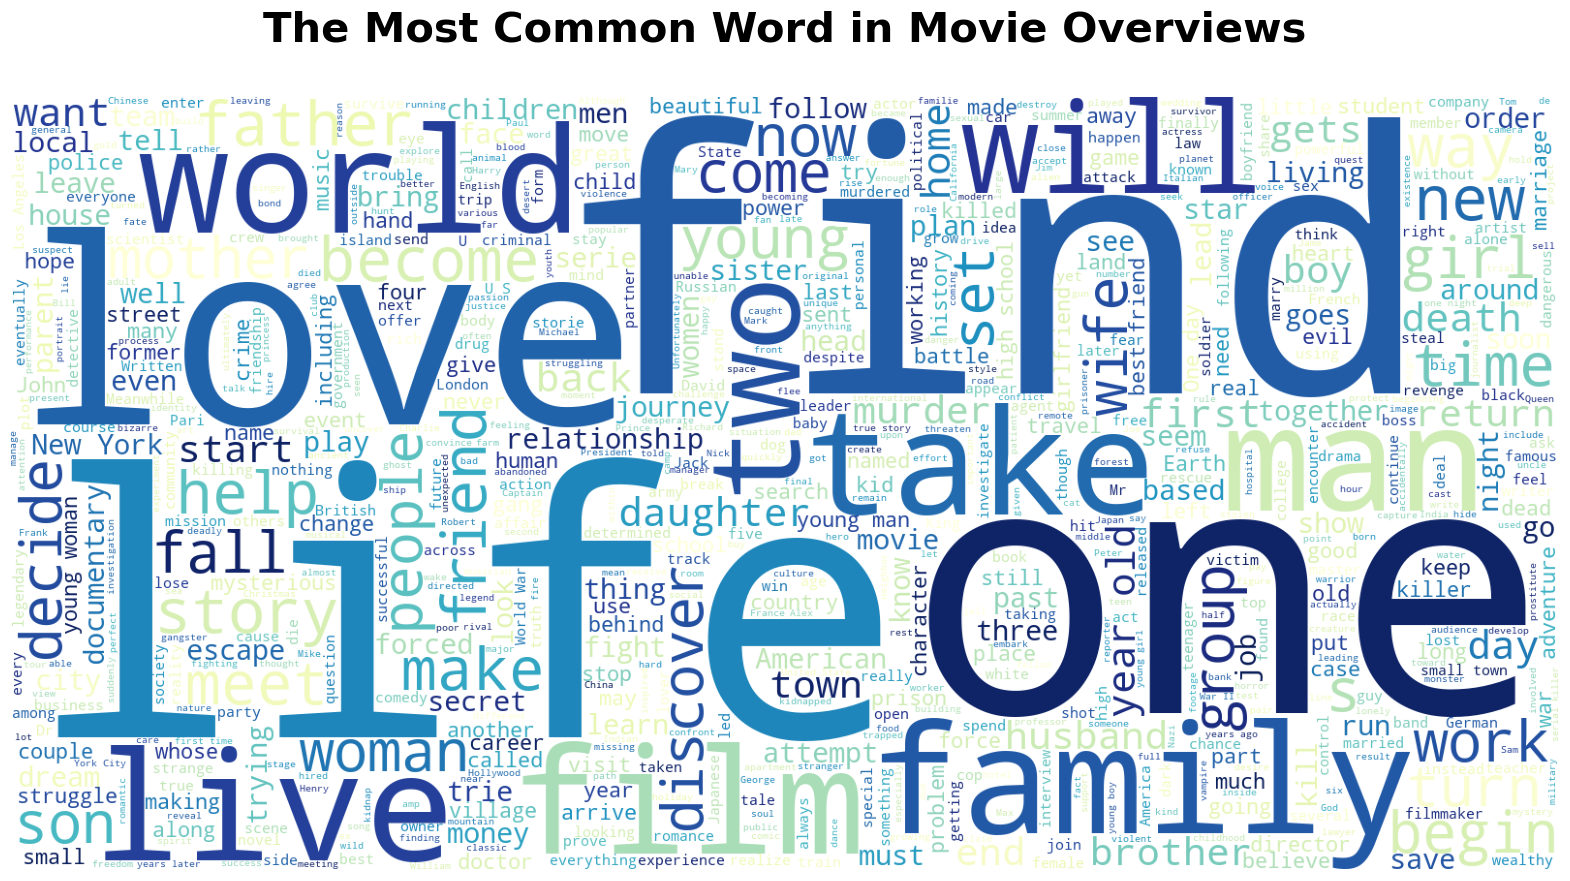

In [51]:
plt.figure(figsize=(20, 20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='black')  # Change title color to light blue

# Use more disorganized settings for the word cloud
wc = WordCloud(max_words=1000, min_font_size=10, height=800, width=1600,
               background_color="white", colormap="YlGnBu_r",  # Change colormap to Blues for a bright blue color scheme
               relative_scaling=0.3,  # Adjust relative scaling for a more disorganized appearance
               ).generate(' '.join(df['overview']))

plt.axis('off')
plt.imshow(wc)

# Show the plot
plt.show()

(-1.25, 1.25, -1.25, 1.25)

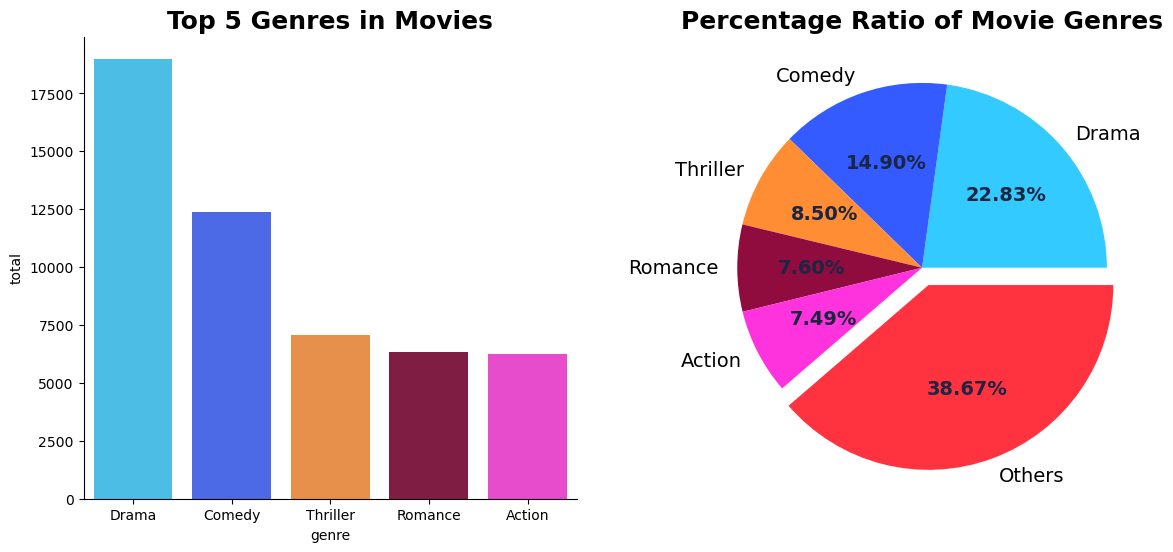

In [14]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#33CAFF', '#335BFF', '#FF8D33', '#900C3F', '#FF33DD'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='black')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='black')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#33CAFF', '#335BFF', '#FF8D33', '#900C3F', '#FF33DD', '#FF333F'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

In [30]:

df['release_year'] = df['release_date'].dt.year

# Get data
data = df['release_year'].value_counts().sort_index()

# Create trace
trace = go.Scatter(x=data.index,
                   y=data.values,
                   marker=dict(color='#db0000'))

# Create layout
layout = dict(title=dict(text='{} Movies Grouped By Year Of Release'.format(df["id"].shape[0]),
                         x=0.5,  # Set x to 0.5 for center alignment
                         xanchor='center',  # Anchor point for x-axis
                         y=0.95),  # Adjust y to move the title higher or lower
              xaxis=dict(title='Release Year'), 
              yaxis=dict(title='Movies'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

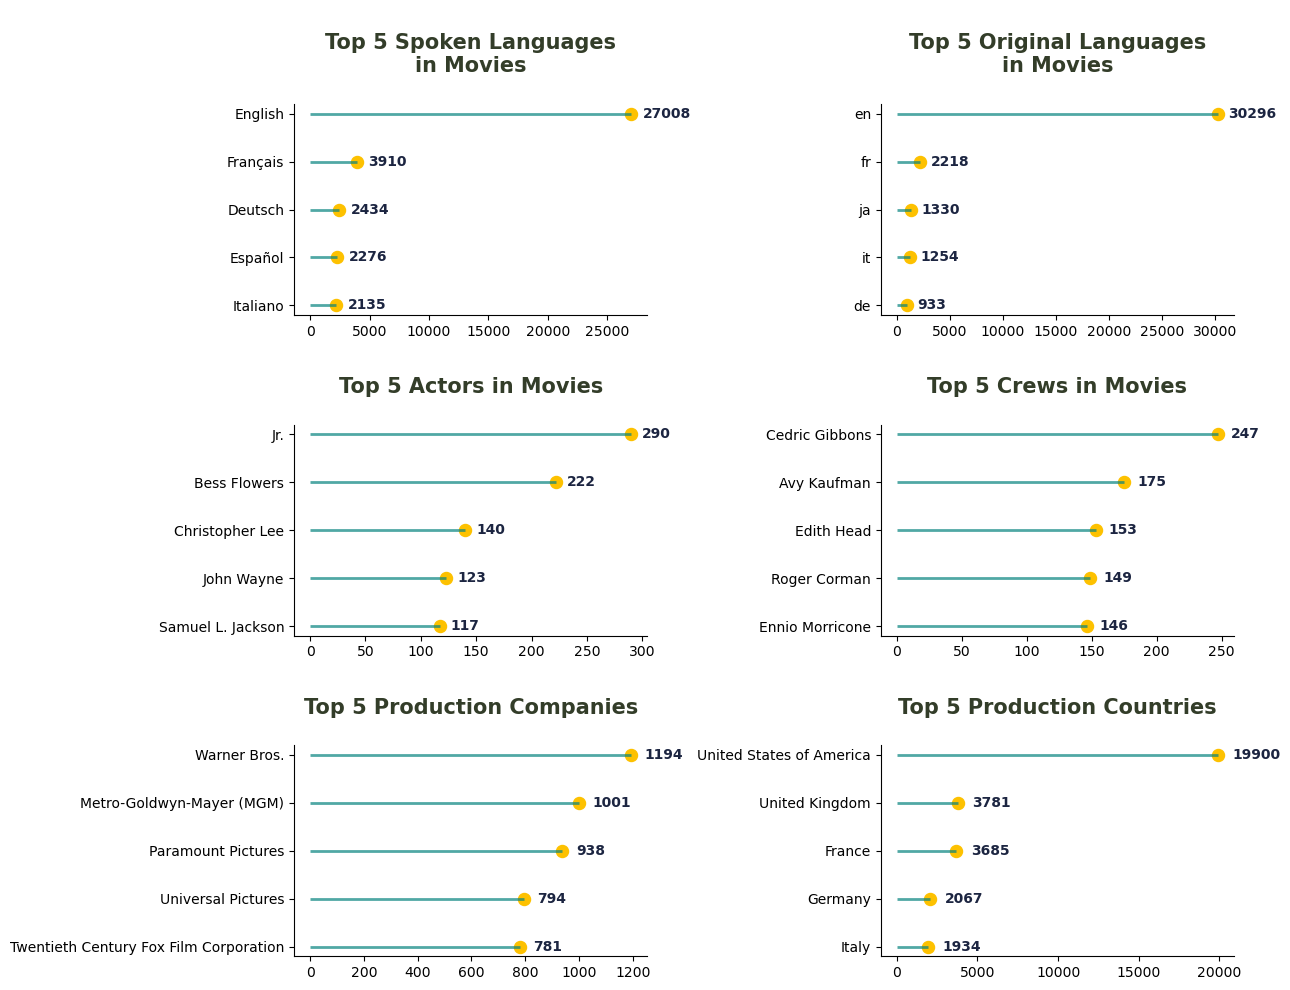

In [24]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))
        
        
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='black')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

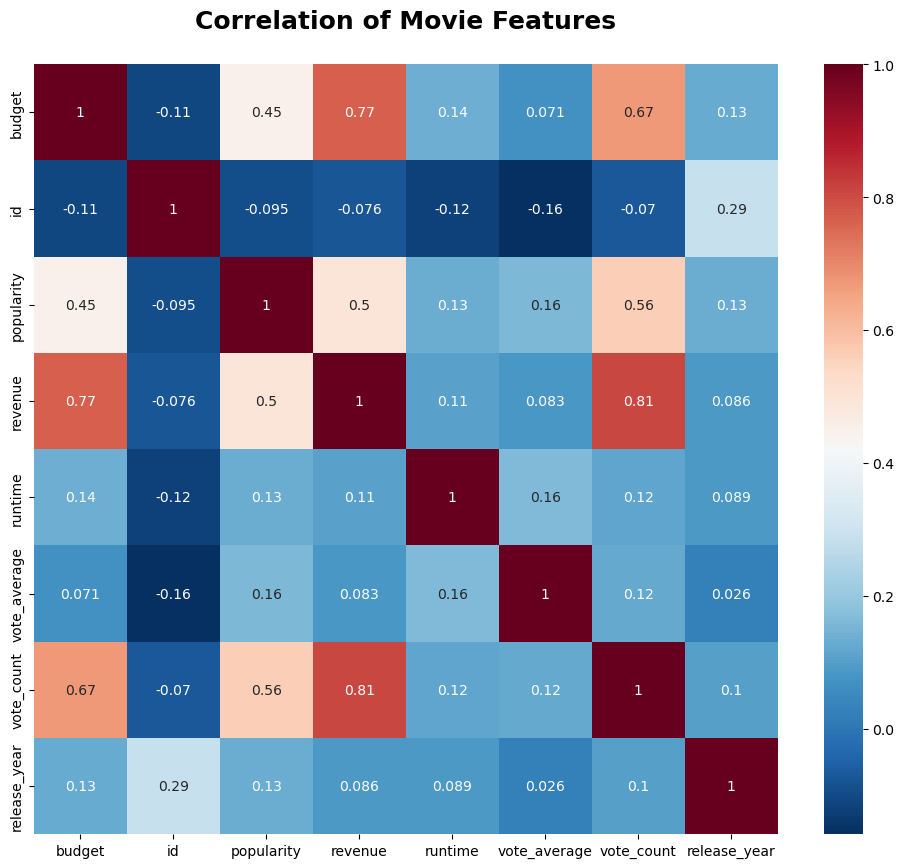

In [27]:
plt.figure(figsize=(12, 10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='black')

# Use 'RdBu_r' color map for red-to-blue transition
cmap = 'RdBu_r'

# Plot the heatmap
sns.heatmap(df.corr(), annot=True, cmap=cmap)

plt.show()

# RECOMMEND SYSTEM

Using hybrid but base only on the movies watched


In [4]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [5]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

Let's take 30% weight for weigthed average and 70% weight for popularity considering people don't want to miss a hype movie even the reviews and ratings are poor. 

In [6]:
weighted_df['score'] = weighted_df['weighted_average']*0.3 + weighted_df['popularity'].astype('float64')*0.7

In [7]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.881060
Big Hero 6,0.390602,0.827561,0.521690
Baby Driver,0.416507,0.727736,0.509876
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.475418
Deadpool,0.343132,0.764657,0.469589
Avatar,0.338036,0.732643,0.456418
Pulp Fiction,0.257449,0.908395,0.452733
Gone Girl,0.282748,0.843413,0.450947
John Wick,0.335843,0.699476,0.444933


we will combine those score with the similarity score

In [8]:
hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [9]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [10]:
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [11]:
hybrid_df = weighted_df_sorted.merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(42373, 75210)

In [12]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(42373, 42373)

In [13]:
# hybrid_df
hybrid_df.reset_index()

,original_title,popularity,weighted_average,score,bag_of_words
0,Minions,1.000000,0.603532,0.881060,false family animation adventure comedy minion...
1,Big Hero 6,0.390602,0.827561,0.521690,false adventure family animation action comedy...
2,Baby Driver,0.416507,0.727736,0.509876,false action crime after being coerced into wo...
3,Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.475418,false action adventure comedy science fiction ...
4,Deadpool,0.343132,0.764657,0.469589,false action adventure comedy deadpool tells t...
...,...,...,...,...,...
42368,Birdemic: Shock and Terror,0.004621,0.155452,0.049870,false horror science fiction a platoon of eagl...
42369,Epic Movie,0.010136,0.141691,0.049603,false action adventure comedy when edward pete...
42370,Battlefield Earth,0.009638,0.127443,0.044980,false action science fiction war in the year ...
42371,Dragonball Evolution,0.016213,0.084011,0.036552,false action adventure fantasy science fiction...


In [14]:
import joblib
# Save the preprocessed data and cosine similarity matrix
hybrid_df.to_csv('../data//hybrid_df.csv')
joblib.dump(cos_sim, '../data/cosine_similarity_matrix.joblib')

['../data/cosine_similarity_matrix.joblib']

prediction


In [15]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [18]:
predict('Toy Story', similarity_weight=0.8, top_n=10)

,score,similarity,final_score
original_title,,,
Avatar,0.456418,1.000000,0.945642
From Justin to Kelly,0.107700,0.301167,0.281821
Indiana Jones and the Temple of Doom,0.234245,0.281078,0.276395
Boys and Girls,0.149958,0.280054,0.267045
Avatar 2,0.007697,0.284288,0.256629
Dudley Do-Right,0.107158,0.261964,0.246483
Popstar: Never Stop Never Stopping,0.192025,0.251422,0.245482
Austin Powers in Goldmember,0.167937,0.249381,0.241237
Anonymous,0.189108,0.244652,0.239097
